Saved figures to 'figures/' with Springboks colours.


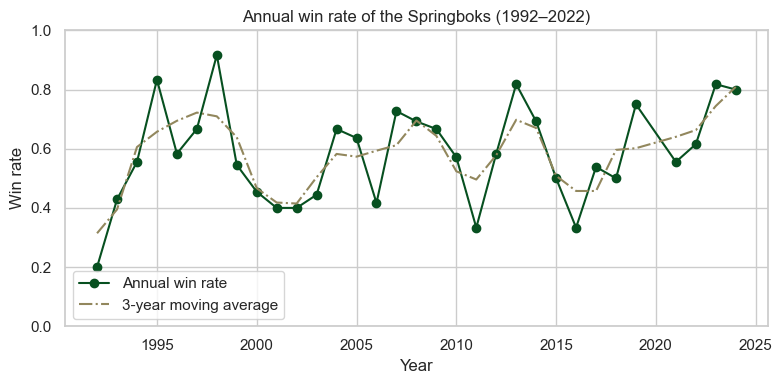

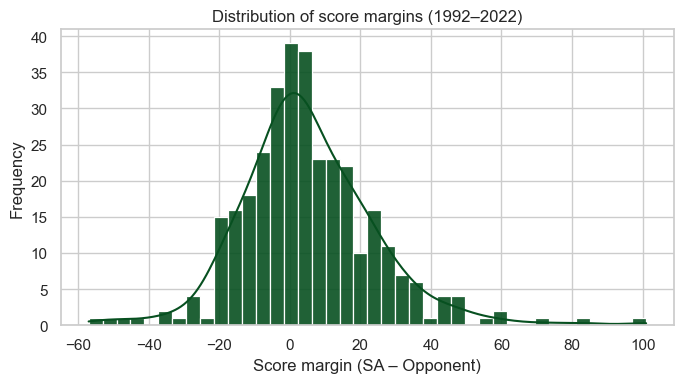

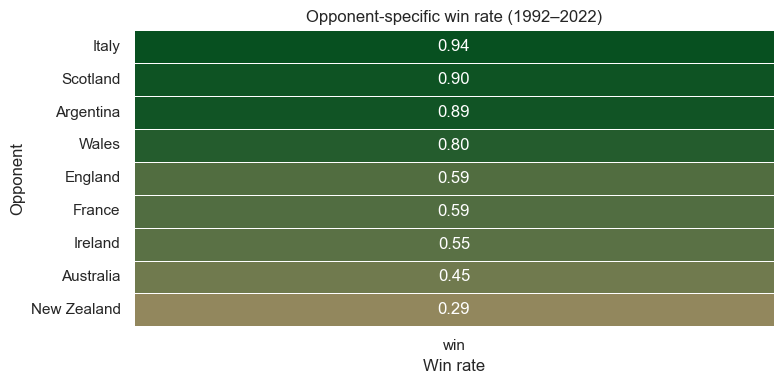

In [5]:
# !pip install pandas numpy matplotlib seaborn pyarrow statsmodels

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    HAS_LOWESS = True
except Exception:
    HAS_LOWESS = False

# --- Springboks colour scheme ---
PRIMARY = "#075020"   # green
SECONDARY = "#92875d" # gold/khaki
bok_cmap = LinearSegmentedColormap.from_list("bok_cmap", [SECONDARY, PRIMARY])

sns.set_theme(style="whitegrid")
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=[PRIMARY, SECONDARY])

GOLD = Path("data/gold/gold_results.parquet")
FIG = Path("figures"); FIG.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(GOLD)

# 1) Annual win rate with smoothing
annual = df.groupby(df["date"].dt.year)["win"].mean().rename("winrate").reset_index()
x = annual["date"].values; y = annual["winrate"].values

plt.figure(figsize=(8,4))
plt.plot(x, y, marker="o", linestyle="-", label="Annual win rate", color=PRIMARY)
if HAS_LOWESS and len(annual) >= 5:
    y_s = lowess(y, x, frac=0.4, return_sorted=False)
    plt.plot(x, y_s, linestyle="-.", label="LOWESS", color=SECONDARY)
else:
    y_s = pd.Series(y).rolling(3, center=True, min_periods=1).mean().values
    plt.plot(x, y_s, linestyle="-.", label="3-year moving average", color=SECONDARY)
plt.ylim(0,1)
plt.ylabel("Win rate"); plt.xlabel("Year")
plt.title("Annual win rate of the Springboks (1992–2022)")
plt.legend(); plt.tight_layout()
plt.savefig(FIG / f"prelim_winrate_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.pdf", 
            bbox_inches="tight")

# 2) Score margin histogram
plt.figure(figsize=(7,4))
sns.histplot(df["score_margin"].dropna(), bins=40, kde=True,
             color=PRIMARY, edgecolor="white", alpha=0.9)
plt.xlabel("Score margin (SA – Opponent)"); plt.ylabel("Frequency")
plt.title("Distribution of score margins (1992–2022)")
plt.tight_layout()
plt.savefig(FIG / f"prelim_margin_hist_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.pdf", 
            bbox_inches="tight")

# 3) Opponent-specific win rate heatmap
opp_rates = (df.groupby("opp_team")["win"].mean().sort_values(ascending=False)).reset_index()
plt.figure(figsize=(8, max(4, 0.25*len(opp_rates))))
sns.heatmap(
    opp_rates.set_index("opp_team")[["win"]],
    annot=True, fmt=".2f", cmap=bok_cmap, cbar=False,
    linewidths=0.5, linecolor="white"
)
plt.title("Opponent-specific win rate (1992–2022)")
plt.ylabel("Opponent"); plt.xlabel("Win rate")
plt.tight_layout()
plt.savefig(FIG / f"prelim_opponent_heatmap_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.pdf", 
            bbox_inches="tight")

print("Saved figures to 'figures/' with Springboks colours.")
